In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

drive_path = "Data Studies/datasets/Hourly Energy Consumption/"
base_path = "gdrive/MyDrive/" + drive_path

df_PJME_path = base_path + "PJME_hourly.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Energy Consumption - Time Series Forecasting Study

by **Diego Kurashima**: [Linkedin](www.linkedin.com/in/diego-jun-sato-kurashima)

This notebook is a study on the [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data) dataset for **Time Series Forecasting** problems. For this study I'll focus on the **PJM East Region** (**PJME**) data

Forecasting is about solving problems. The Problems defined for this study were:
1.  **Problem 1** - One Year Forecast with Datetime features
2.  **Problem 2** - One Year Forecast with Time Series features (and Datetime features)

I focused the Exploratory Analysis (EDA) on **Datetime** and **Time Series Features** and used **XGBoost** for prediction.

## Importing the Data

In [3]:
df_PJME_raw = pd.read_csv(df_PJME_path)

df_PJME = df_PJME_raw.copy()
df_PJME['Datetime'] = pd.to_datetime(df_PJME['Datetime'])

print("PJME Data Info:")
print(df_PJME.info())
print("\n")

print("PJME Head:")
print(df_PJME.head())
print("\n")

print("PJME Tail:")
print(df_PJME.tail())
print("\n")

PJME Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB
None


PJME Head:
             Datetime  PJME_MW
0 2002-12-31 01:00:00  26498.0
1 2002-12-31 02:00:00  25147.0
2 2002-12-31 03:00:00  24574.0
3 2002-12-31 04:00:00  24393.0
4 2002-12-31 05:00:00  24860.0


PJME Tail:
                  Datetime  PJME_MW
145361 2018-01-01 20:00:00  44284.0
145362 2018-01-01 21:00:00  43751.0
145363 2018-01-01 22:00:00  42402.0
145364 2018-01-01 23:00:00  40164.0
145365 2018-01-02 00:00:00  38608.0




## Exploratory Analysis (EDA)

Let's get an **overall description** of the data.

In [4]:
df_PJME.describe()

,Datetime,PJME_MW
count,145366,145366.000000
mean,2010-04-18 03:25:25.999202048,32080.222831
min,2002-01-01 01:00:00,14544.000000
25%,2006-02-23 14:15:00,27573.000000
50%,2010-04-18 04:30:00,31421.000000
75%,2014-06-10 18:45:00,35650.000000
max,2018-08-03 00:00:00,62009.000000
std,NaN,6464.012166


From the 'Datetime' columns, we can see that the data is not ordered: the min 'Datetime' is '2002-01-01 01:00:00' while from .head() the first index is '2002-12-31 01:00:00'.

I'll check for **duplicates** (rows).

In [5]:
print("Check of Duplicates:")
print(f"{df_PJME[df_PJME.duplicated()]}")

print("Check of Duplicates (Datetimes):")
print(f"{df_PJME[df_PJME['Datetime'].duplicated()]}")

Check of Duplicates:
Empty DataFrame
Columns: [Datetime, PJME_MW]
Index: []
Check of Duplicates (Datetimes):
                  Datetime  PJME_MW
106585 2014-11-02 02:00:00  23755.0
115369 2015-11-01 02:00:00  21171.0
124009 2016-11-06 02:00:00  21692.0
132817 2017-11-05 02:00:00  20666.0


Some Duplicates Dates were found.

Now, let's check for **Missing Dates** based on the period in a hourly basis.

In [6]:
missing_dates = pd.date_range(start=pd.to_datetime('2002-01-01 01:00:00'), end=pd.to_datetime('2018-08-03 00:00:00'), freq='h').difference(df_PJME['Datetime'])
missing_dates

DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [7]:
print(f"Missing Dates: {len(missing_dates)}")

Missing Dates: 30


Some missing datetime were found. I'll handle them later when analysing the Time Series Features.

### EDA - Overall Analysis


Let's create an **overall plot** of the energy consumption data for the whole period of the dataset.

<ipython-input-8-55160037acbe>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model', loc='upper left', fontsize=10)


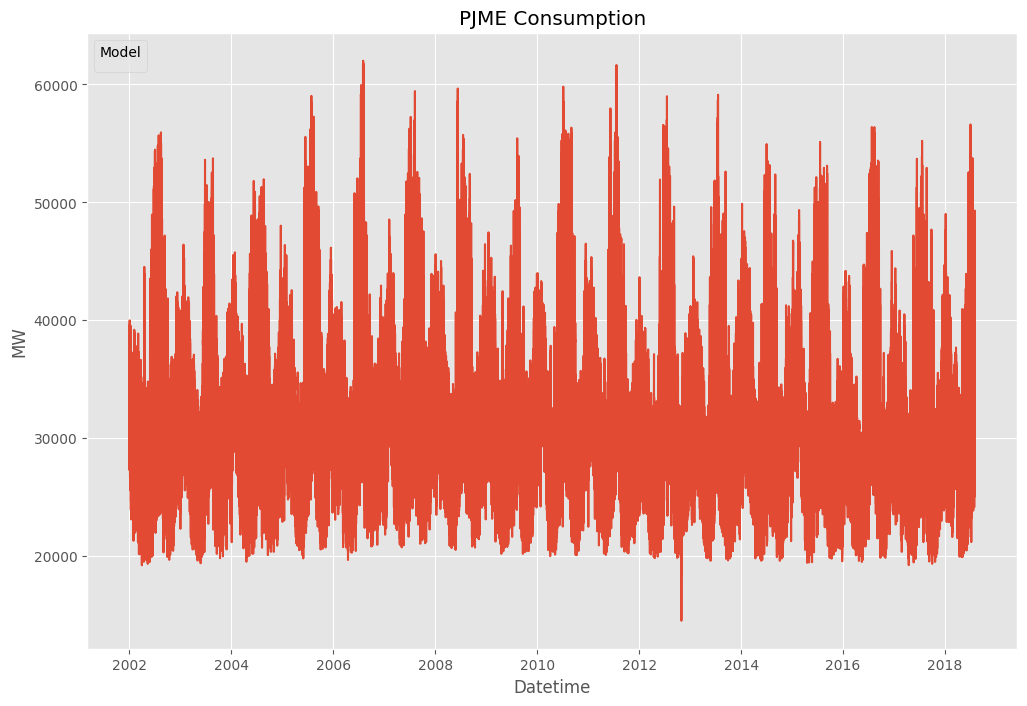

In [8]:
# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME, x='Datetime', y='PJME_MW')

plt.title('PJME Consumption')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Model', loc='upper left', fontsize=10)
plt.grid(True)

We'll also plot a **Histogram** and a **Boxplot** to better understand the data.

Text(0.5, 1.0, 'Histogram for MW')

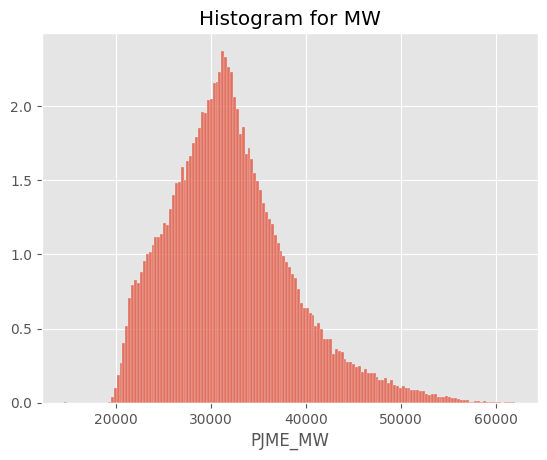

In [9]:
sns.histplot(data=df_PJME, x="PJME_MW", stat='percent')
plt.xlabel("PJME_MW")
plt.ylabel('')
plt.title('Histogram for MW')

Text(0.5, 1.0, 'Boxplot for MW')

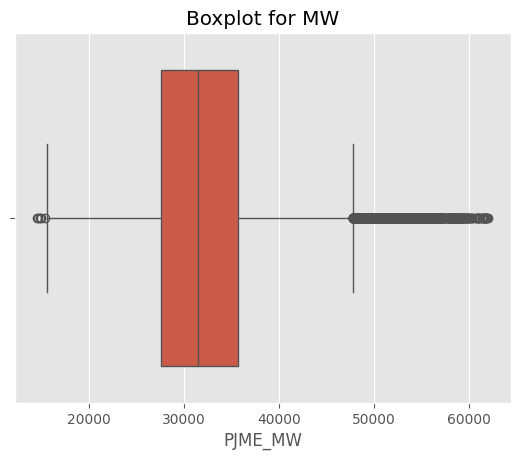

In [10]:
sns.boxplot(data=df_PJME, x="PJME_MW")
plt.xlabel("PJME_MW")
plt.ylabel('')
plt.title('Boxplot for MW')

From the data we may infer the data is slightly skewed (**Positive Skew**). Let's chek the skewness mathematically.

In [11]:
print(f"Skew: {df_PJME['PJME_MW'].skew()}")

Skew: 0.7390115207783634


Since the skew is greater than zero (>0) we confirm that the data for PJME_MW is slightly skewed to the left.

### EDA - Datetime


Since it is a time series data, let's analyse the data based on the datetime: **Year**, **Quarter**, **Month**, **Date**, **Hour**, ...

In addition, let's create feature whether it **Is_Weekend** or not.

I'll also create a feature to show **Season** based on USA Seasons (with full month):
1.  Spring
2.  Summer
3.  Fall
4.  Winter



In [12]:
def create_features_Datetime(df_PJME):

  # Standard Datetime Features
  df_PJME['Year'] = df_PJME['Datetime'].dt.year
  df_PJME['Quarter'] = df_PJME['Datetime'].dt.quarter
  df_PJME['Month'] = df_PJME['Datetime'].dt.month
  df_PJME['Day'] = df_PJME['Datetime'].dt.day
  df_PJME['Hour'] = df_PJME['Datetime'].dt.hour

  df_PJME['Day_of_Year'] = df_PJME['Datetime'].dt.dayofyear

  df_PJME['Weekday'] = df_PJME['Datetime'].dt.weekday
  df_PJME['Is_Weekend'] =  df_PJME['Datetime'].dt.day_name().isin(['Saturday', 'Sunday'])

  # SEASON Feature
  def create_feature_Season(row):
    if 3 <= row['Datetime'].month <= 5:
      return 1
    elif 6 <= row['Datetime'].month <= 8:
      return 2
    elif 9 <= row['Datetime'].month <= 11:
      return 3
    else:
      return 4

  df_PJME['Season'] = df_PJME.apply(create_feature_Season, axis = 1)
  df_PJME['Season_Name'] = df_PJME['Season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

  return df_PJME

df_PJME = create_features_Datetime(df_PJME)

In [13]:
df_PJME.head(5)

,Datetime,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season,Season_Name
0,2002-12-31 01:00:00,26498.0,2002,4,12,31,1,365,1,False,4,Winter
1,2002-12-31 02:00:00,25147.0,2002,4,12,31,2,365,1,False,4,Winter
2,2002-12-31 03:00:00,24574.0,2002,4,12,31,3,365,1,False,4,Winter
3,2002-12-31 04:00:00,24393.0,2002,4,12,31,4,365,1,False,4,Winter
4,2002-12-31 05:00:00,24860.0,2002,4,12,31,5,365,1,False,4,Winter


Let's check the effect of Month, Hour and Weekday to the data.

Text(0.5, 1.0, 'PJME_MW by Weekday')

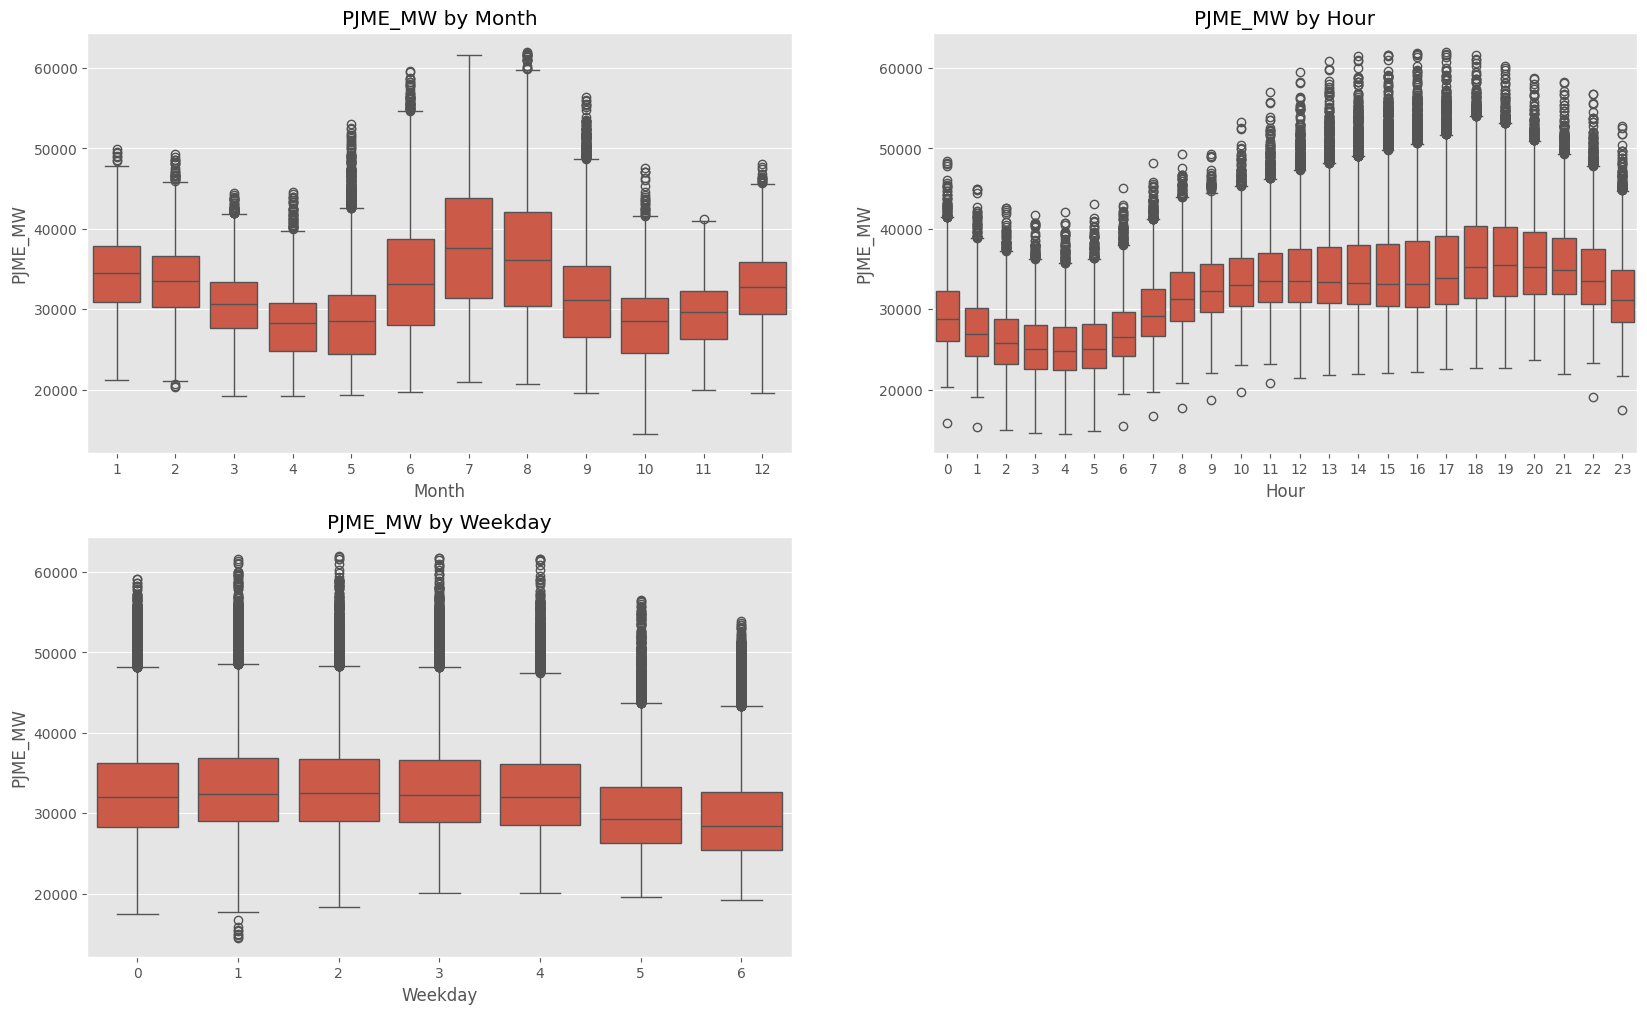

In [14]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Month')
plt.title('PJME_MW by Month')

plt.subplot(2,2,2)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Hour')
plt.title('PJME_MW by Hour')

plt.subplot(2,2,3)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Weekday')
plt.title('PJME_MW by Weekday')

Let's check if the Season affects the distribution of the data.

Text(0.5, 1.0, 'PJME_MW by Season')

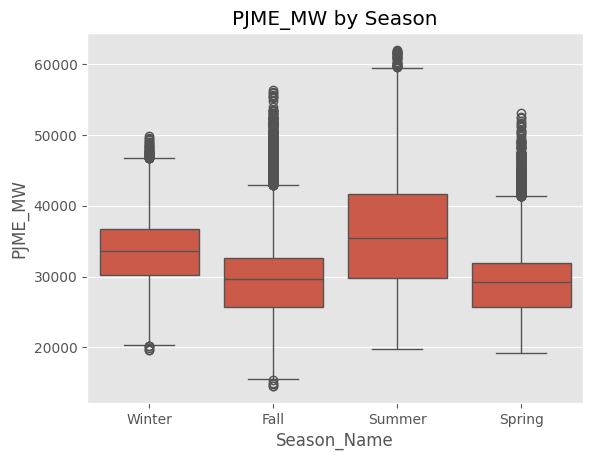

In [15]:
sns.boxplot(data=df_PJME, y="PJME_MW", x='Season_Name')
plt.title('PJME_MW by Season')

We could see a a pattern for "Month" and "Season" which resembles a sinusoidal wave.

For Hours it was also possible to identify a pattern, with higher consumption at the afternoon.

### EDA - Time Series Features

Now, we'll analyse the time series components. The main components of a Time Series are:
1.  Trends
2.  Seasonality
3.  Cycles
4.  Residuals

The dataframe has some Missing Datetimes as seen before. Let's create an alternate dataframe (df_PJME_ts) resampling the data to **fill the missing dates** and **deal with duplicates** with interpolation.

In [16]:
df_PJME_ts_raw = df_PJME_raw.copy()
df_PJME_ts_raw['Datetime'] = pd.to_datetime(df_PJME_ts_raw['Datetime'])

df_PJME_ts = df_PJME_ts_raw.copy()

# Reindex
df_PJME_ts = df_PJME_ts.set_index('Datetime').sort_index()
df_PJME_ts = df_PJME_ts.resample('h').mean()

# Interpolate
df_PJME_ts['PJME_MW'] = df_PJME_ts['PJME_MW'].interpolate(method='time')

# Reset Datetime
df_PJME_ts = df_PJME_ts.reset_index('Datetime')

# Create Datetime features
df_PJME_ts = create_features_Datetime(df_PJME_ts)

# Set Index
#df_PJME_ts = df_PJME_ts.set_index('Datetime')


In [17]:
df_PJME_ts.head()

,Datetime,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season,Season_Name
0,2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,False,4,Winter
1,2002-01-01 02:00:00,29265.0,2002,1,1,1,2,1,1,False,4,Winter
2,2002-01-01 03:00:00,28357.0,2002,1,1,1,3,1,1,False,4,Winter
3,2002-01-01 04:00:00,27899.0,2002,1,1,1,4,1,1,False,4,Winter
4,2002-01-01 05:00:00,28057.0,2002,1,1,1,5,1,1,False,4,Winter


In [18]:
df_PJME_ts.describe()

,Datetime,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Season
count,145392,145392.000000,145392.000000,145392.000000,145392.000000,145392.000000,145392.00000,145392.000000,145392.000000,145392.000000
mean,2010-04-18 00:30:00,32078.927654,2009.800704,2.481196,6.435836,15.722529,11.50000,180.455252,2.999525,2.478362
min,2002-01-01 01:00:00,14544.000000,2002.000000,1.000000,1.000000,1.000000,0.00000,1.000000,0.000000,1.000000
25%,2006-02-23 12:45:00,27571.000000,2006.000000,1.000000,3.000000,8.000000,5.75000,90.000000,1.000000,1.000000
50%,2010-04-18 00:30:00,31420.000000,2010.000000,2.000000,6.000000,16.000000,11.50000,179.000000,3.000000,2.000000
75%,2014-06-10 12:15:00,35647.000000,2014.000000,3.000000,9.000000,23.000000,17.25000,271.000000,5.000000,3.000000
max,2018-08-03 00:00:00,62009.000000,2018.000000,4.000000,12.000000,31.000000,23.00000,366.000000,6.000000,4.000000
std,NaN,6464.283311,4.791740,1.114472,3.438967,8.801313,6.92221,105.138733,1.999713,1.123420


In [19]:
missing_dates = pd.date_range(start=pd.to_datetime('2002-01-01 01:00:00'), end=pd.to_datetime('2018-08-03 00:00:00'), freq='h').difference(df_PJME_ts['Datetime'])
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='h')

Let's plot the **Autocorrelation** to understand possible trends and seasonality.

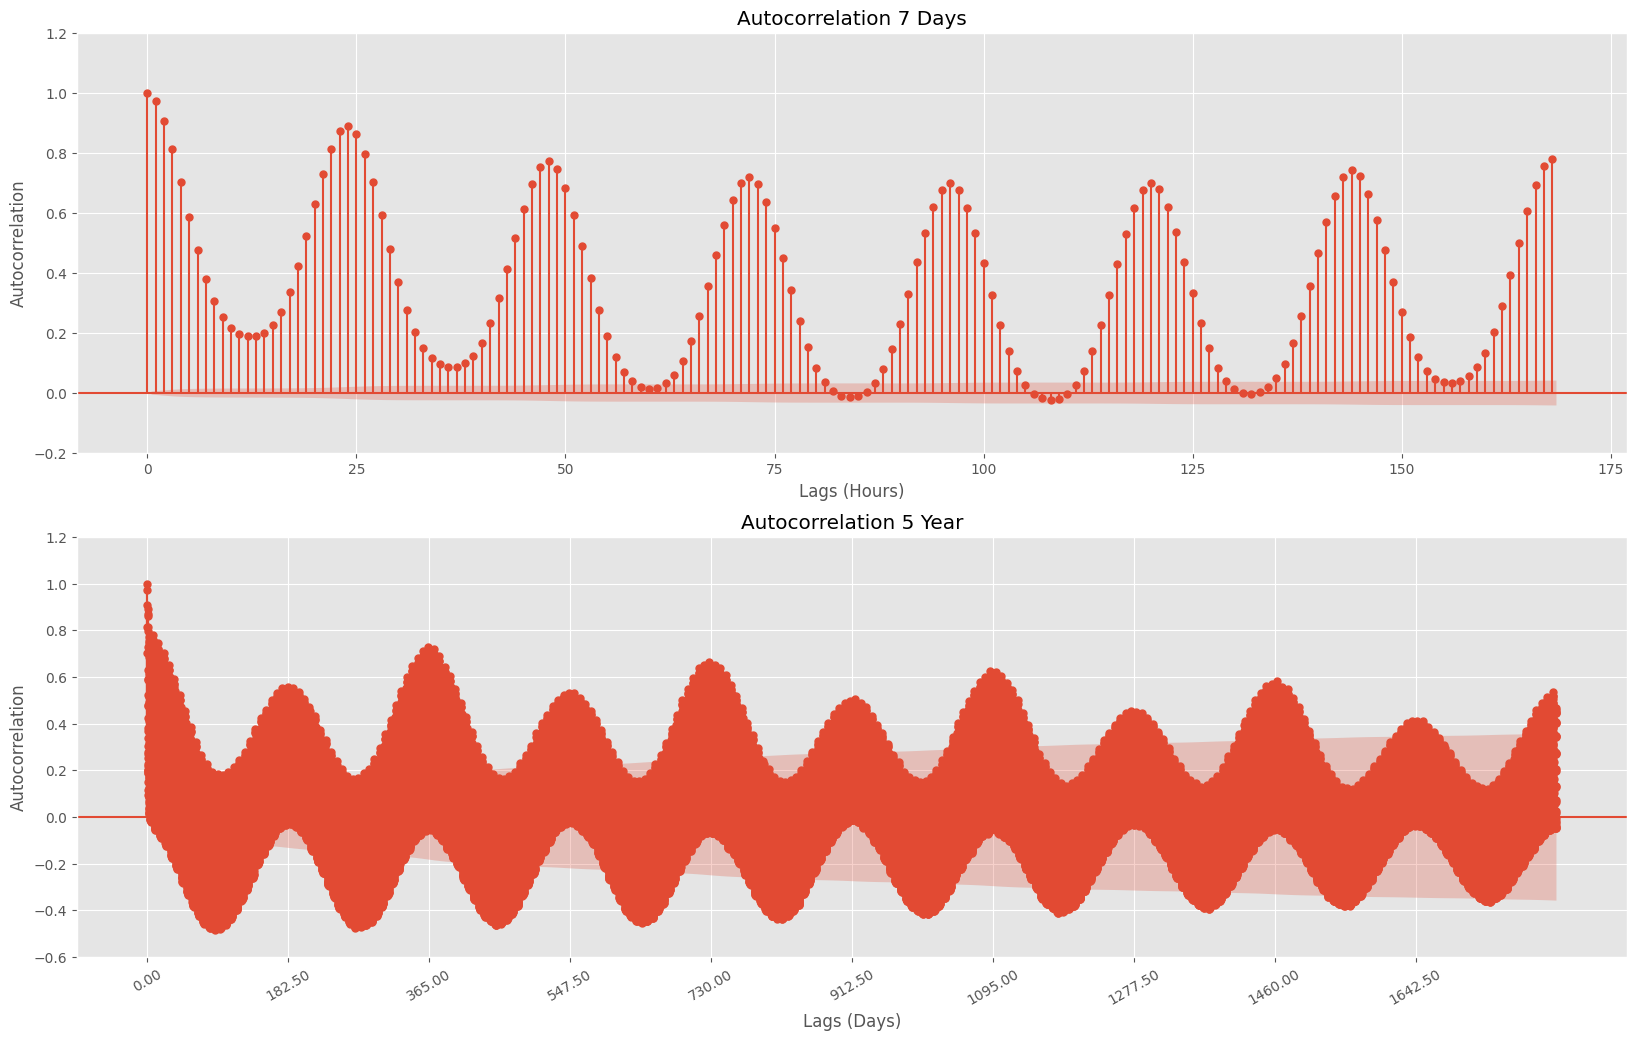

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

plot_acf(df_PJME_ts['PJME_MW'], lags=24*7, ax=ax[0])

ax[0].set_title('Autocorrelation 7 Days')
ax[0].set_xlabel('Lags (Hours)')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_ylim(-0.2, 1.2)
ax[0].grid(True)

plot_acf(df_PJME_ts['PJME_MW'], lags=24*365*5, ax=ax[1])

ax[1].set_title('Autocorrelation 5 Year')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_ylim(-0.6, 1.2)

ax[1].set_xlabel('Lags (Days)')

hours_featured = [i for i in range(0, 5*365*24, 365*12)]
ax[1].set_xticks(hours_featured)

days_featured =  [f"{hour/(24):.2f}" for hour in hours_featured]
ax[1].set_xticklabels(days_featured, rotation=30)
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax[1].grid(True)

From the **7 Days** autocorrelation, it is possible to identify a possible seasonality for a 24 hours (1 day) period.

From the **5 Years** autocorrelation, it is also possible to detect a seasonality every half year (6 months).

From both, we can observe a **slow decay** in the autocorrelation, which could indicate a long-term dependancy (trend).

Let's use "**seasonal_decompose**" from "statsmodels" library to get a first decomposition of the data into Trends, Seasonality and Residuals.

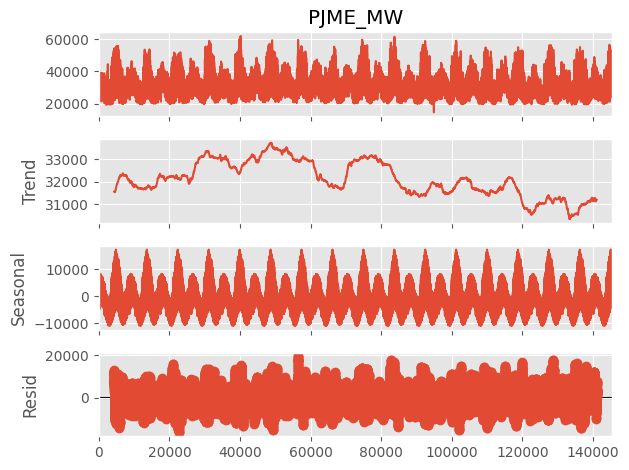

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_PJME_ts['PJME_MW'], model='additive', period=365*24)
result.plot()
plt.show()

From the decomposition, we may infer that there is a relatively stable long-term pattern, which could indicate stationarity, and a Seasonality.

Let's start with **Trends**.

We'll create a **Rolling Average** for a **1 Year** and **2 Years** window.

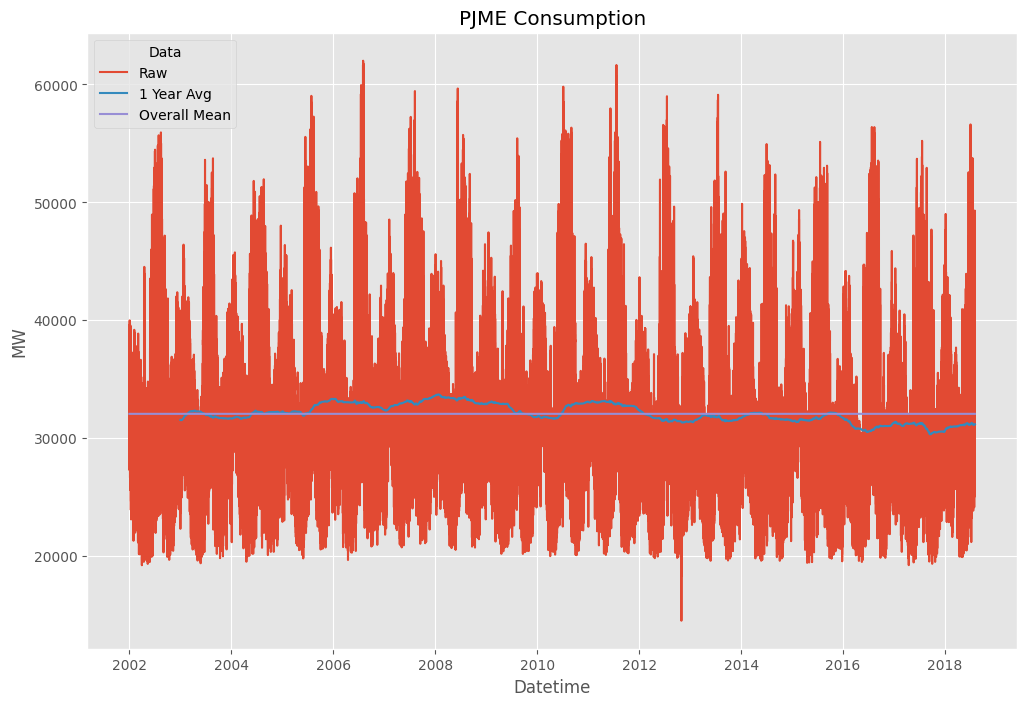

In [22]:
df_PJME_ts[f'PJME_MW_Avg{1}y'] = df_PJME_ts['PJME_MW'].rolling(24*365*1).mean()
#df_PJME_ts[f'PJME_MW_Avg{2}y'] = df_PJME_ts['PJME_MW'].rolling(24*365*2).mean()
df_PJME_ts['PJME_MW_Mean'] = df_PJME_ts['PJME_MW'].mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME_ts, x='Datetime', y='PJME_MW', label ="Raw")
sns.lineplot(data=df_PJME_ts, x='Datetime', y=f'PJME_MW_Avg{1}y', label="1 Year Avg")
#sns.lineplot(data=df_PJME_ts, x='Datetime', y=f'PJME_MW_Avg{2}y', label="2 Year Avg")
sns.lineplot(data=df_PJME_ts, x='Datetime', y=f'PJME_MW_Mean', label="Overall Mean")


plt.title('PJME Consumption')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)


There isn't any particular increase or decrease in the mean value of PJME_MW, so we may infer the data is stationary from this data.

To verify the stationarity of the data we'll do a **Hypothesis Test** with  **Augmented Dickey Fuller Test** (ADF Test):
1.  Null Hypothesis: the time series has an Unit Root (Non-Stationary)
2.  Alternate Hypothesis: the time series is Stationary.

In [23]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_PJME_ts['PJME_MW'])
test_statistic, p_value, _, _, _, _ = adf_result

print(f'ADF Statistic: {test_statistic}')
print(f'P-value: {p_value}')

if p_value <= 0.05:
	print('Reject the null hypothesis: The time series is Stationary.')
else:
	print('Fail to reject the null hypothesis: The time series is Non-Stationary.')

ADF Statistic: -19.96459393184053
P-value: 0.0
Reject the null hypothesis: The time series is Stationary.


Since we reject the null hypothesis, we may conclude that the PJME_MW series is **Stationary**.

Now, for **Seasonality**.

Let's plot the **periodogram** of the data.

<ipython-input-24-f1fe22613173>:4: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


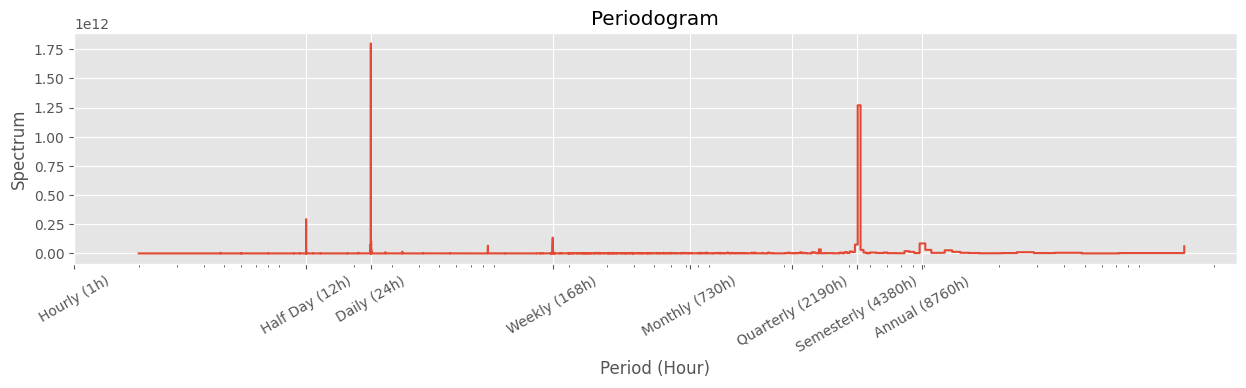

In [24]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df_PJME_ts['PJME_MW'])
periods = 1 / frequencies

fig, ax = plt.subplots(figsize=(15, 3))
ax.step(periods, spectrum)
ax.set_title('Periodogram')
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')

periods_featured = [1, 12, 24, 24*7, int(24*365/12), int(24*365/4), int(24*365/2), 24*365]
ax.set_xticks(periods_featured)
ax.set_xticklabels(["Hourly (1h)",
                    "Half Day (12h)",
                    f"Daily (24h)",
                    f"Weekly ({periods_featured[3]}h)",
                    f"Monthly ({periods_featured[4]}h)",
                    f"Quarterly ({periods_featured[5]}h)",
                    f"Semesterly ({periods_featured[6]}h)",
                    f"Annual ({periods_featured[7]}h)"],
                   rotation=30)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.xlabel('Period (Hour)')
plt.ylabel('Spectrum')
plt.show()

We can identify a strong **Daily** and **Semesterly** seasonalities.

Let's create a **30 days** window average to analyse the effects of a **Semesterly** seasonality for each year.

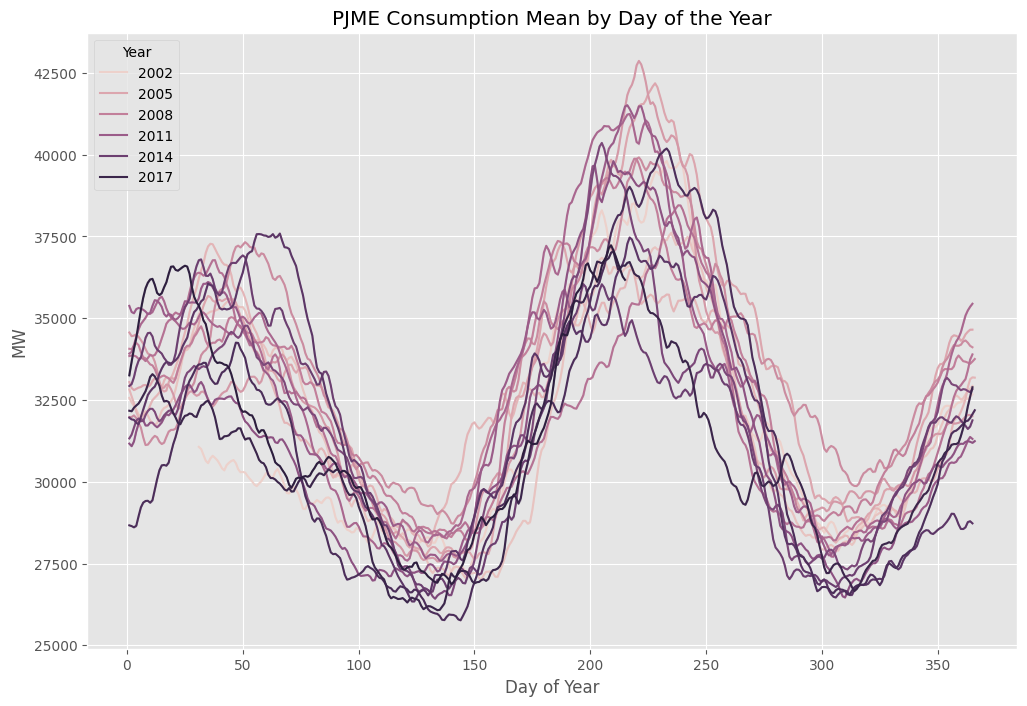

In [25]:
df_PJME_ts[f'PJME_MW_Avg{30}d'] = df_PJME_ts['PJME_MW'].rolling(24*30).mean()

# Plots
plt.figure(figsize=(12, 8))

#sns.lineplot(data=df_PJME_ts, x='Day_of_Year', y=f'PJME_MW', hue = 'Year')
sns.lineplot(data=df_PJME_ts, x='Day_of_Year', y=f'PJME_MW_Avg{30}d', hue = 'Year')

plt.title('PJME Consumption Mean by Day of the Year')
plt.xlabel('Day of Year')
plt.ylabel('MW')
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True)

From the plot we can identify a strong pattern which repeats twice a year, similar to a sinusoidal wave, indicating that there is indeed a strong Semesterly seasonality.

Now let's check any pattern which repeats **Daily**. Let's group PJME_MW by Year and Hour to check these effects.

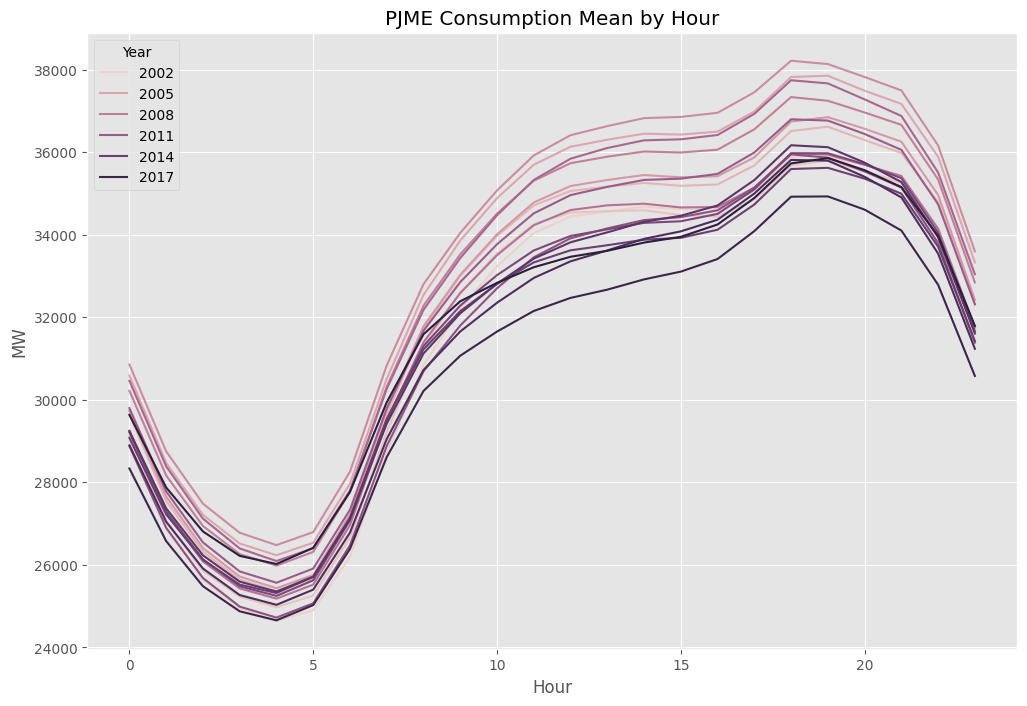

In [26]:
# Create Year and Month features
df_PJME_gbYearHour_meanMW = df_PJME_ts[['Year', 'Hour', 'PJME_MW']].groupby(['Year', 'Hour'])['PJME_MW'].mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME_gbYearHour_meanMW.reset_index(), x='Hour', y='PJME_MW', hue = 'Year')

plt.title('PJME Consumption Mean by Hour')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True)

From the plot, we can identify a pattern which repeats each year in a single day, indicating a Daily pattern as the periodogram inferred.

As for **Cycles**.

Let's plot **Partial Autocorrelation** for **7 days lags**.

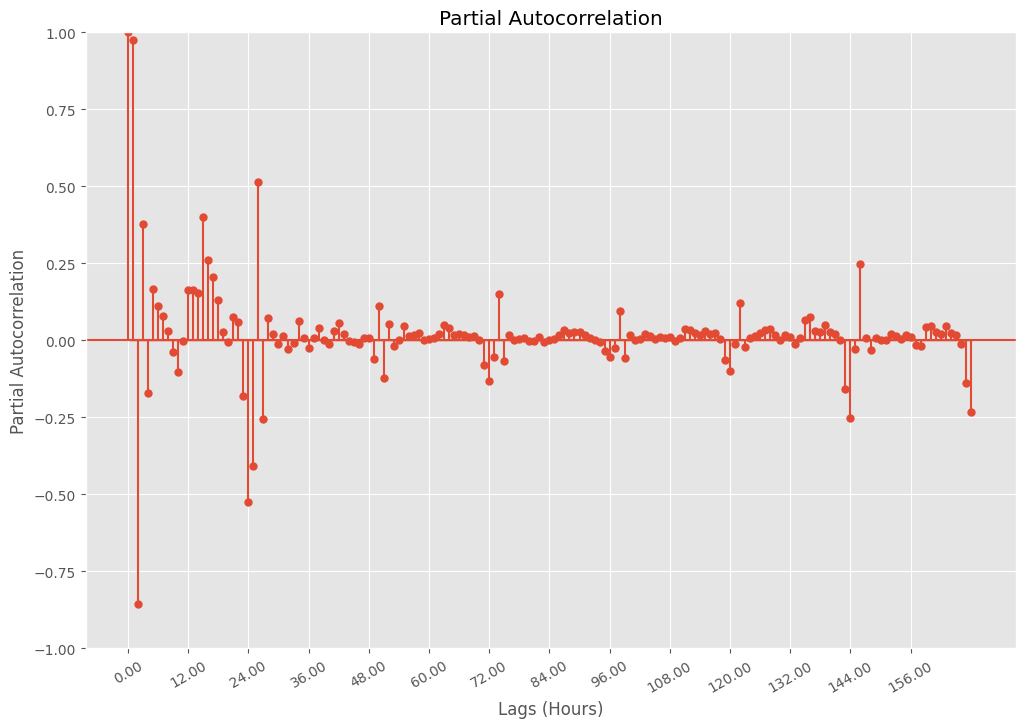

In [27]:
# Plots
fig, ax = plt.subplots(1,1, figsize=(12, 8))

#plt.subplot(2,2,2)
plot_pacf(df_PJME_ts['PJME_MW'], lags=24*7, ax=ax)
ax.set_title('Partial Autocorrelation')
ax.set_xlabel('Lags (Hours)')
ax.set_ylabel('Partial Autocorrelation')

x_featured = [i for i in range(0, 24*7, 12)]
ax.set_xticks(x_featured)

x_label =  [f"{x:.2f}" for x in x_featured]
ax.set_xticklabels(x_label, rotation=30)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

#plt.legend(title='Model', loc='upper left', fontsize=10)
ax.grid(True)


From the plot, we may infer a strong partial autocorrelation the **24 hour** lagged data. Also for **1** and **2 hours** lag.

Since this pattern repeats for lags with more days lagged as well, the partial autocorrelation also suggests a strong daily cyclicity for the data

## Problem 1 - One Year Forecast Forecast with Datetime Features

Let's define as our **Problem 1** the Forecast of PJME_MW based only on **datetime features** (such as Year, Month, Hour ...).

Since it is based only on datetime features, past values (lags and moving window statistics) will not matter in this first problem.

We'll set the data until 2017 as the Training and Test Data, and the data for 2018 as the Validation Data:
1.  **Training and Test**: data until 2017 Year
2.  **Validation**: 2018 Year

For the Problem 1, we'll model with **XGB Regressor**, using cross-validation using Time Series Split with 5 folds.

In [28]:
def cross_val_time_series(xgb, df, cols_train, cols_target, split_years):

  preds = []
  cv_scores = []

  for split in split_years:
    train = df[df['Year'] < split]
    test = df[df['Year'] == split]

    X_train = train[cols_train]
    y_train = train[cols_target]

    X_test = test[cols_train]
    y_test = test[cols_target]

    xgb.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = xgb.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test, y_pred)
    cv_scores.append(score)

  return preds, cv_scores

In [29]:
df_p1 = df_PJME_ts.copy()

# Define Train and Target Columns
cols_train = ['Year', 'Quarter', 'Month', 'Day', 'Hour', 'Day_of_Year', 'Weekday', 'Is_Weekend', 'Season']
cols_target = ["PJME_MW"]

# Split Training and Validation Dataset
df_p1_training = df_p1[df_p1['Year'] <= 2017]
df_p1_validation = df_p1[df_p1['Year'] == 2018]

# XGB Regressor
reg_xgb = xgb.XGBRegressor(booster='gbtree',n_estimators=1000)

# Split Training into TRAIN and TEST for CROSS-VALIDATION
# Manual Cross-Validation
split_years = [2005, 2010, 2015, 2016, 2017]
p1_xgb_preds, p1_xgb_cv_scores = cross_val_time_series(reg_xgb, df_p1_training, cols_train, cols_target, split_years)

[0]	validation_0-rmse:4901.03814	validation_1-rmse:5825.05665
[100]	validation_0-rmse:906.64577	validation_1-rmse:4268.23648
[200]	validation_0-rmse:603.39946	validation_1-rmse:4354.78389
[300]	validation_0-rmse:467.63569	validation_1-rmse:4369.84438
[400]	validation_0-rmse:380.26032	validation_1-rmse:4395.16984
[500]	validation_0-rmse:321.11001	validation_1-rmse:4404.87034
[600]	validation_0-rmse:280.71969	validation_1-rmse:4412.64853
[700]	validation_0-rmse:249.57986	validation_1-rmse:4416.39515
[800]	validation_0-rmse:224.10903	validation_1-rmse:4419.95153
[900]	validation_0-rmse:206.42036	validation_1-rmse:4420.38749
[999]	validation_0-rmse:190.99518	validation_1-rmse:4422.76095
[0]	validation_0-rmse:5097.48237	validation_1-rmse:5704.30458
[100]	validation_0-rmse:1360.33425	validation_1-rmse:4375.05257
[200]	validation_0-rmse:1003.19669	validation_1-rmse:4444.02158
[300]	validation_0-rmse:822.35347	validation_1-rmse:4472.33718
[400]	validation_0-rmse:713.51433	validation_1-rmse:448

In [30]:
print(f'XGB - Mean Overall RMSE: {np.mean(p1_xgb_cv_scores):0.4f}')
print(f'XGB - Each Fold RMSE:{p1_xgb_cv_scores}')

XGB - Mean Overall RMSE: 4539.9930
XGB - Each Fold RMSE:[4422.7607421875, 4518.84716796875, 4220.6474609375, 4571.22705078125, 4966.482421875]


Now, let's **Train** on the whole Training Data (until 2017 Year)

In [31]:
# TRAINING Proper
X_all = df_p1_training[cols_train]
y_all = df_p1_training[cols_target]

reg_p1 = xgb.XGBRegressor(booster='gbtree',n_estimators=1000)

reg_p1.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:5221.46863
[100]	validation_0-rmse:1795.33058
[200]	validation_0-rmse:1417.53757
[300]	validation_0-rmse:1215.42902
[400]	validation_0-rmse:1067.72334
[500]	validation_0-rmse:971.31229
[600]	validation_0-rmse:892.10961
[700]	validation_0-rmse:828.64701
[800]	validation_0-rmse:779.86729
[900]	validation_0-rmse:737.11225
[999]	validation_0-rmse:698.13414


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Now we'll **Predict** the data for 2018, and compare with real values.

In [32]:
# PREDICTION
X_val = df_p1_validation[cols_train]
y_val = df_p1_validation[cols_target]

y_pred = reg_p1.predict(X_val)

# Dataframe with Predictions
df_p1_pred = df_p1_validation.copy()
df_p1_pred['PJME_MW_Pred'] = y_pred

# Overall RMSE

print("Problem 1 - RESULTS\n")

rmse_full = root_mean_squared_error(y_val, y_pred)
print(f"RMSE Overall: {rmse_full}")
print("\n")

# RMSE for each Month
for month in range(1,13):
  try:
    rmse = root_mean_squared_error(df_p1_pred[df_p1_pred['Month'] == month]['PJME_MW'], df_p1_pred[df_p1_pred['Month'] == month]['PJME_MW_Pred'])
    print(f"RMSE (month: {month}): {rmse}")
  except:
    pass
print("\n")

# RMSE for each Hour
for hour in range(0,24):
  try:
    rmse = root_mean_squared_error(df_p1_pred[df_p1_pred['Hour'] == hour]['PJME_MW'], df_p1_pred[df_p1_pred['Hour'] == hour]['PJME_MW_Pred'])
    print(f"RMSE (hour: {hour}): {rmse}")
  except:
    pass
print("\n")

Problem 1 - RESULTS

RMSE Overall: 4528.865234375


RMSE (month: 1): 5958.1028336103345
RMSE (month: 2): 3062.2117335870666
RMSE (month: 3): 2822.9438752143806
RMSE (month: 4): 2588.544330823484
RMSE (month: 5): 5189.7234362299205
RMSE (month: 6): 5248.863928197142
RMSE (month: 7): 5370.65578436233
RMSE (month: 8): 3387.8426923133366


RMSE (hour: 0): 4083.709751882278
RMSE (hour: 1): 3934.813289738751
RMSE (hour: 2): 3878.0613787267025
RMSE (hour: 3): 3869.235354431182
RMSE (hour: 4): 3860.707381486876
RMSE (hour: 5): 3912.9591969260787
RMSE (hour: 6): 3926.509760523899
RMSE (hour: 7): 3938.7358419975526
RMSE (hour: 8): 3960.3589251886638
RMSE (hour: 9): 3904.7766633072465
RMSE (hour: 10): 3942.9881537135043
RMSE (hour: 11): 4199.805748997068
RMSE (hour: 12): 4497.92648186435
RMSE (hour: 13): 4806.601270893651
RMSE (hour: 14): 5017.716376118149
RMSE (hour: 15): 5172.3834779096305
RMSE (hour: 16): 5297.516788123731
RMSE (hour: 17): 5449.6591405489935
RMSE (hour: 18): 5426.458044066522


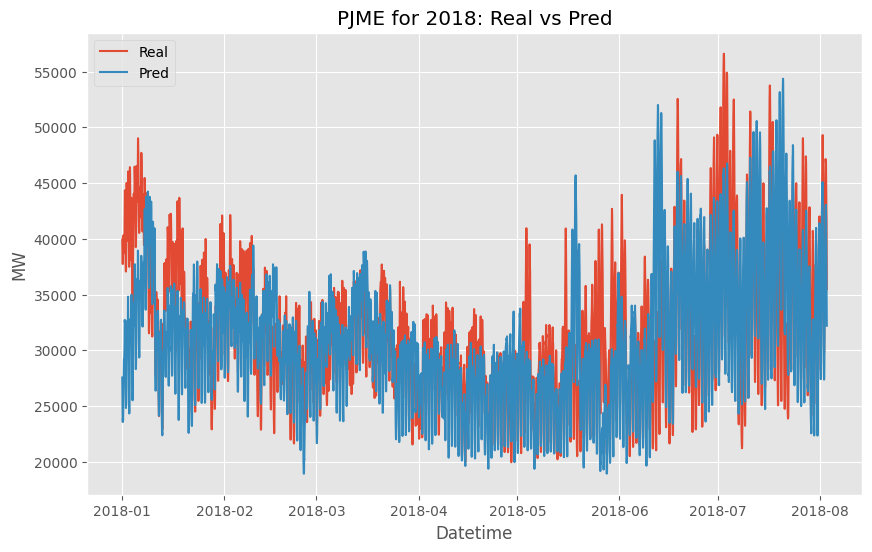

In [33]:
# Plots
plt.figure(figsize=(10,6))

plt.subplot(1,1,1)

sns.lineplot(data=df_p1_pred, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p1_pred, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

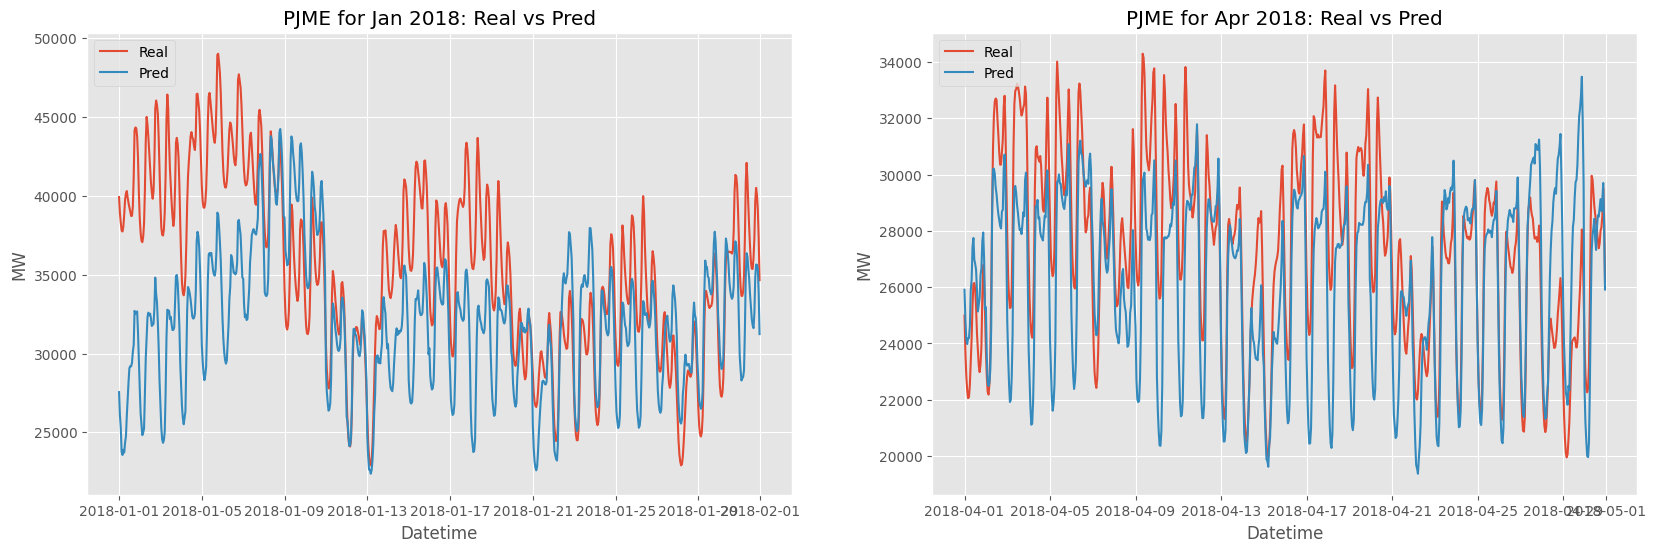

In [34]:
# Plots
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
df_p1_pred_Feb = df_p1_pred[df_p1_pred['Month'] == 1]

sns.lineplot(data=df_p1_pred_Feb, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p1_pred_Feb, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for Jan 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(1,2,2)
df_p1_pred_Apr = df_p1_pred[df_p1_pred['Month'] == 4]

sns.lineplot(data=df_p1_pred_Apr, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p1_pred_Apr, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for Apr 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

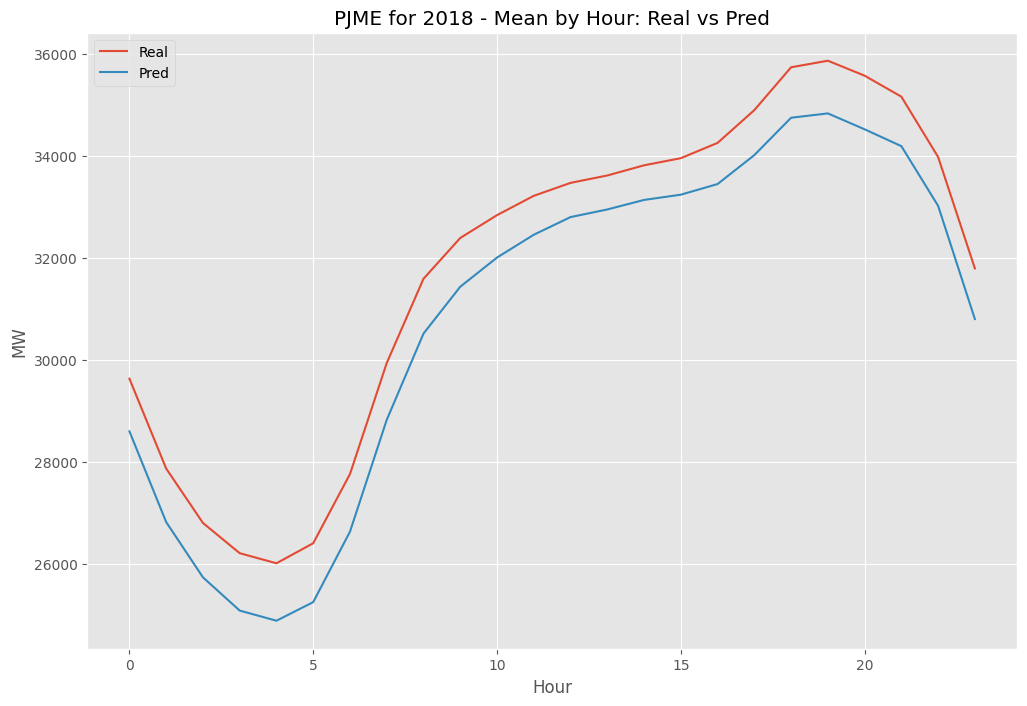

In [35]:
# Create Year and Month features
df_p1_pred_gbHour_meanMW = df_p1_pred[['Hour', 'PJME_MW', 'PJME_MW_Pred']].groupby(['Hour'])[['PJME_MW', 'PJME_MW_Pred']].mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_p1_pred_gbHour_meanMW.reset_index(), x='Hour', y='PJME_MW', label='Real')
sns.lineplot(data=df_p1_pred_gbHour_meanMW.reset_index(), x='Hour', y='PJME_MW_Pred', label='Pred')

plt.title('PJME for 2018 - Mean by Hour: Real vs Pred')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

### Conclusions for Problem 1

The XGB Model was able to capture the overall yearly seasonality with some flaws. Some months had lower performance, such as January, compared to April.

The Prediction captured the seasonality for each hours, though the values were lower.

In this first approach, we did not consider Time Series Features, such as lags and moving window statistics, which we will consider in the Problem 2.

## Problem 2 - One Year Forecast with Time Series Features

For the Problem 2, we'll consider the effets of **Time Series Features**, mainly Lags.

One important observation is that it is now important to define which data will be available when the prediction is done. That means, understanding which Lags and Moving Statistics will be available at the time of the prediction.

So for this problem we have:
1.  **Forecast Origin**: data until 2017
2.  **Forecast Horizon**: 2018 onwards

So all the lags defined for this problem are related to data with one year lag and backwards:
*   Previous Year MW and Shifts (1, 2, 24 and 26 Hours)
*   Two Previous Years MW

which are based on the Partial Autocorrelation analysis made earlier.

For this problem we also removed "Year" and "Is_Weekend" features, mainly due to stationarity and week weekly seasonality, respectively.

In [36]:
df_p2 = df_PJME_ts_raw.copy()

# FEATURE Engineering
df_p2 = df_p2.set_index("Datetime")

# Prev Year feature
from pandas.tseries.offsets import DateOffset
df_p2_prev1Y = df_p2.shift(freq = pd.DateOffset(years = 1)).rename(columns={"PJME_MW": "PJME_MW_prev1Year"})['PJME_MW_prev1Year']
df_p2_prev2Y = df_p2.shift(freq = pd.DateOffset(years = 2)).rename(columns={"PJME_MW": "PJME_MW_prev2Year"})['PJME_MW_prev2Year']

df_p2 = df_p2.join(df_p2_prev1Y)
df_p2 = df_p2.join(df_p2_prev2Y)

# Shifted Prev Year
df_p2['PJME_MW_prev1Year_lag1H'] = df_p2['PJME_MW_prev1Year'].shift(1)
df_p2['PJME_MW_prev1Year_lag2H'] = df_p2['PJME_MW_prev1Year'].shift(2)

df_p2['PJME_MW_prev1Year_lag24H'] = df_p2['PJME_MW_prev1Year'].shift(24)
df_p2['PJME_MW_prev1Year_lag26H'] = df_p2['PJME_MW_prev1Year'].shift(26)

# Reset Index
df_p2 = df_p2.reset_index()

# Datetime features
df_p2 = create_features_Datetime(df_p2)

df_p2 = df_p2.dropna()

# Check
df_p2.head()

,Datetime,PJME_MW,PJME_MW_prev1Year,PJME_MW_prev2Year,PJME_MW_prev1Year_lag1H,PJME_MW_prev1Year_lag2H,PJME_MW_prev1Year_lag24H,PJME_MW_prev1Year_lag26H,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season,Season_Name
17516,2004-12-31 01:00:00,27160.0,27525.0,26498.0,29563.0,31857.0,30393.0,34332.0,2004,4,12,31,1,366,4,False,4,Winter
17517,2004-12-31 02:00:00,25791.0,26390.0,25147.0,27525.0,29563.0,29265.0,31451.0,2004,4,12,31,2,366,4,False,4,Winter
17518,2004-12-31 03:00:00,25052.0,25892.0,24574.0,26390.0,27525.0,28357.0,30393.0,2004,4,12,31,3,366,4,False,4,Winter
17519,2004-12-31 04:00:00,24797.0,25935.0,24393.0,25892.0,26390.0,27899.0,29265.0,2004,4,12,31,4,366,4,False,4,Winter
17520,2004-12-31 05:00:00,25026.0,26615.0,24860.0,25935.0,25892.0,28057.0,28357.0,2004,4,12,31,5,366,4,False,4,Winter


In [37]:
# Define Train and Target Columns
cols_train = ['Quarter', 'Month', 'Hour', 'Day_of_Year', 'Weekday', 'PJME_MW_prev1Year', 'PJME_MW_prev2Year', 'PJME_MW_prev1Year_lag1H', 'PJME_MW_prev1Year_lag2H', 'PJME_MW_prev1Year_lag24H', 'PJME_MW_prev1Year_lag26H']
cols_target = ["PJME_MW"]

# Split Training and Validation Dataset
df_p2_training = df_p2[df_p2['Year'] <= 2017]
df_p2_validation = df_p2[df_p2['Year'] == 2018]

# XGB Regressor
reg_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           max_depth=3,
                           learning_rate=0.01)

split_years = [2007, 2010, 2015, 2016, 2017]
p2_xgb_preds, p2_xgb_cv_scores = cross_val_time_series(reg_xgb, df_p2_training, cols_train, cols_target, split_years)

[0]	validation_0-rmse:33007.93738	validation_1-rmse:33917.23950
[100]	validation_0-rmse:12631.72569	validation_1-rmse:13426.49242
[200]	validation_0-rmse:5716.92037	validation_1-rmse:6286.96875
[300]	validation_0-rmse:3817.17203	validation_1-rmse:4228.71124
[400]	validation_0-rmse:3378.41726	validation_1-rmse:3762.20995
[500]	validation_0-rmse:3241.67882	validation_1-rmse:3654.05812
[600]	validation_0-rmse:3163.20486	validation_1-rmse:3628.89396
[700]	validation_0-rmse:3114.17147	validation_1-rmse:3626.37671
[800]	validation_0-rmse:3072.63007	validation_1-rmse:3625.75713
[900]	validation_0-rmse:3035.03343	validation_1-rmse:3629.45193
[999]	validation_0-rmse:3001.76416	validation_1-rmse:3634.92113
[0]	validation_0-rmse:33034.26032	validation_1-rmse:33506.47878
[100]	validation_0-rmse:12639.02446	validation_1-rmse:13406.74166
[200]	validation_0-rmse:5749.69542	validation_1-rmse:6556.18898
[300]	validation_0-rmse:3881.84807	validation_1-rmse:4569.40305
[400]	validation_0-rmse:3470.02884	v

In [38]:
print(f'XGB - Mean Overall RMSE: {np.mean(p2_xgb_cv_scores):0.4f}')
print(f'XGB - Each Fold RMSE:{p2_xgb_cv_scores}')

XGB - Mean Overall RMSE: 3753.2575
XGB - Each Fold RMSE:[3634.921142578125, 3674.765625, 3656.1513671875, 3683.933837890625, 4116.515625]


In [39]:
# TRAINING Proper
X_all = df_p2_training[cols_train]
y_all = df_p2_training[cols_target]

reg_p2 = xgb.XGBRegressor(booster='gbtree',n_estimators=1000)

reg_p2.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:5275.31021
[100]	validation_0-rmse:2635.45927
[200]	validation_0-rmse:2360.73602
[300]	validation_0-rmse:2152.63425
[400]	validation_0-rmse:2003.54794
[500]	validation_0-rmse:1875.40712
[600]	validation_0-rmse:1768.61959
[700]	validation_0-rmse:1677.27362
[800]	validation_0-rmse:1586.39608
[900]	validation_0-rmse:1509.71751
[999]	validation_0-rmse:1442.86190


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
# PREDICTION
X_val = df_p2_validation[cols_train]
y_val = df_p2_validation[cols_target]

y_pred = reg_p2.predict(X_val)

# Dataframe with Predictions
df_p2_pred = df_p2_validation.copy()
df_p2_pred['PJME_MW_Pred'] = y_pred

# Overall RMSE

print("Problem 2 - RESULTS\n")

rmse_full = root_mean_squared_error(y_val, y_pred)
print(f"RMSE Overall: {rmse_full}")
print("\n")

# RMSE for each Month
for month in range(1,13):
  try:
    rmse = root_mean_squared_error(df_p2_pred[df_p2_pred['Month'] == month]['PJME_MW'], df_p2_pred[df_p2_pred['Month'] == month]['PJME_MW_Pred'])
    print(f"RMSE (month: {month}): {rmse}")
  except:
    pass
print("\n")

# RMSE for each Hour
for hour in range(0,24):
  try:
    rmse = root_mean_squared_error(df_p2_pred[df_p2_pred['Hour'] == hour]['PJME_MW'], df_p2_pred[df_p2_pred['Hour'] == hour]['PJME_MW_Pred'])
    print(f"RMSE (hour: {hour}): {rmse}")
  except:
    pass
print("\n")

Problem 2 - RESULTS

RMSE Overall: 4252.974609375


RMSE (month: 1): 6380.011355838245
RMSE (month: 2): 3942.5868397667055
RMSE (month: 3): 2264.112417453035
RMSE (month: 4): 1978.3787634744076
RMSE (month: 5): 2845.1010310776405
RMSE (month: 6): 4471.946930852713
RMSE (month: 7): 5781.37661629386
RMSE (month: 8): 2198.085036392298


RMSE (hour: 0): 3720.3082721088035
RMSE (hour: 1): 3773.6252171755623
RMSE (hour: 2): 3864.783918995545
RMSE (hour: 3): 3839.524978723934
RMSE (hour: 4): 3857.7473864936674
RMSE (hour: 5): 3879.68012009973
RMSE (hour: 6): 4054.56871369589
RMSE (hour: 7): 4153.870450605121
RMSE (hour: 8): 3947.7871881572064
RMSE (hour: 9): 3975.1159461163984
RMSE (hour: 10): 4039.1631178350653
RMSE (hour: 11): 4007.9322011790914
RMSE (hour: 12): 4403.1680884213265
RMSE (hour: 13): 4765.169138076271
RMSE (hour: 14): 4842.718604622304
RMSE (hour: 15): 4780.574758903774
RMSE (hour: 16): 4813.558948606057
RMSE (hour: 17): 4834.591722068544
RMSE (hour: 18): 4729.0821455562345
RM

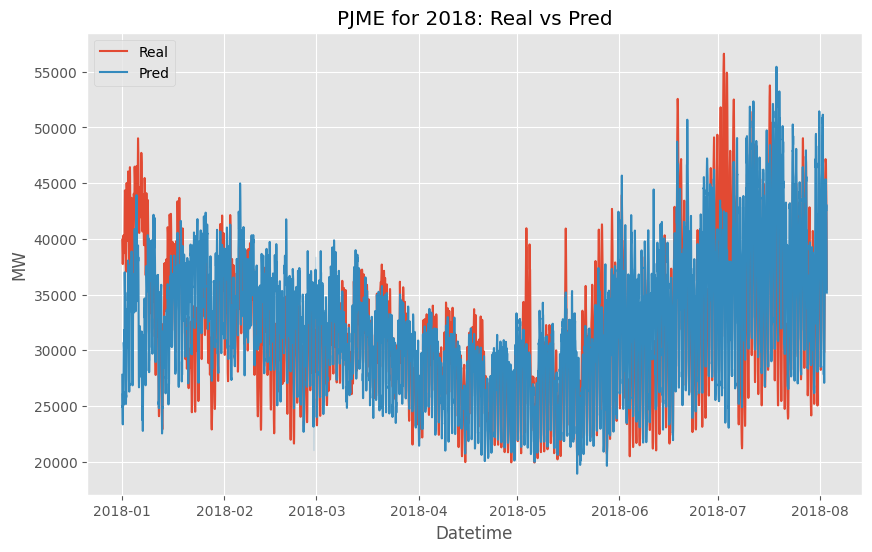

In [41]:
# Plots
plt.figure(figsize=(10,6))

plt.subplot(1,1,1)

sns.lineplot(data=df_p2_pred, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p2_pred, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

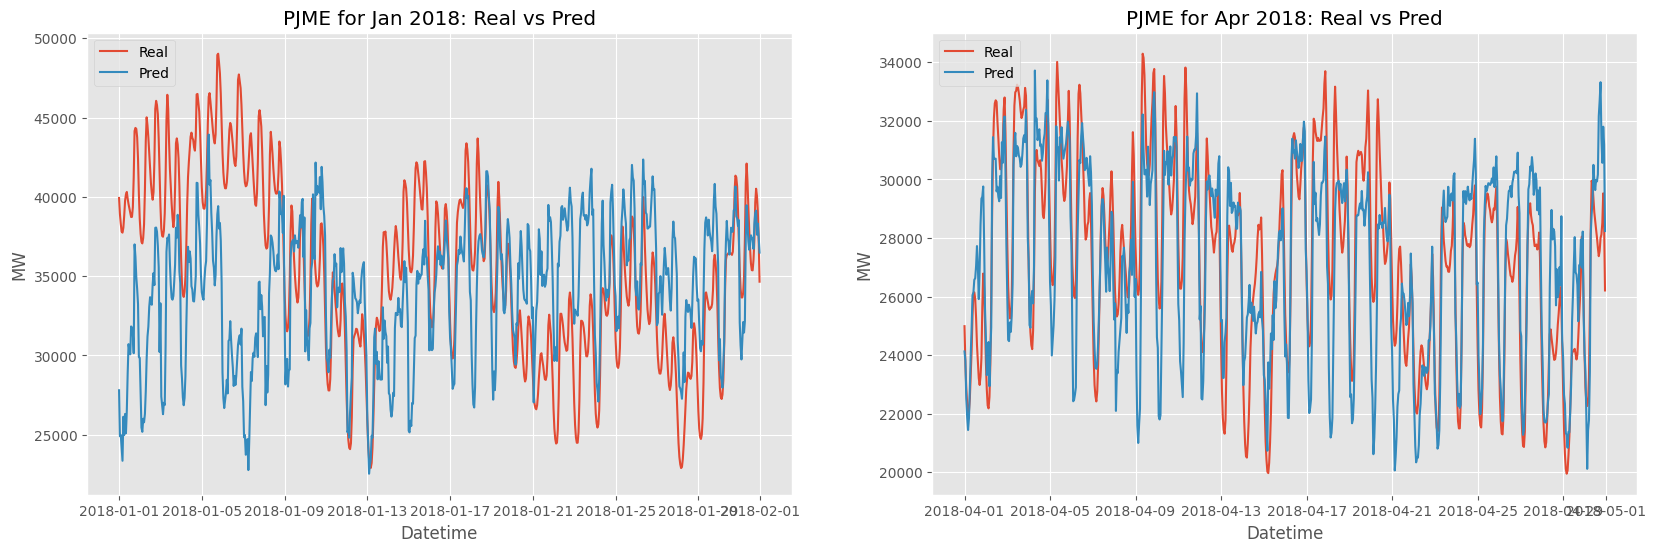

In [42]:
# Plots
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
df_p2_pred_Feb = df_p2_pred[df_p2_pred['Month'] == 1]

sns.lineplot(data=df_p2_pred_Feb, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p2_pred_Feb, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for Jan 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(1,2,2)
df_p2_pred_Apr = df_p2_pred[df_p2_pred['Month'] == 4]

sns.lineplot(data=df_p2_pred_Apr, x='Datetime', y='PJME_MW', label="Real")
sns.lineplot(data=df_p2_pred_Apr, x='Datetime', y='PJME_MW_Pred', label="Pred")

plt.title('PJME for Apr 2018: Real vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='', loc='upper left', fontsize=10)
plt.grid(True)

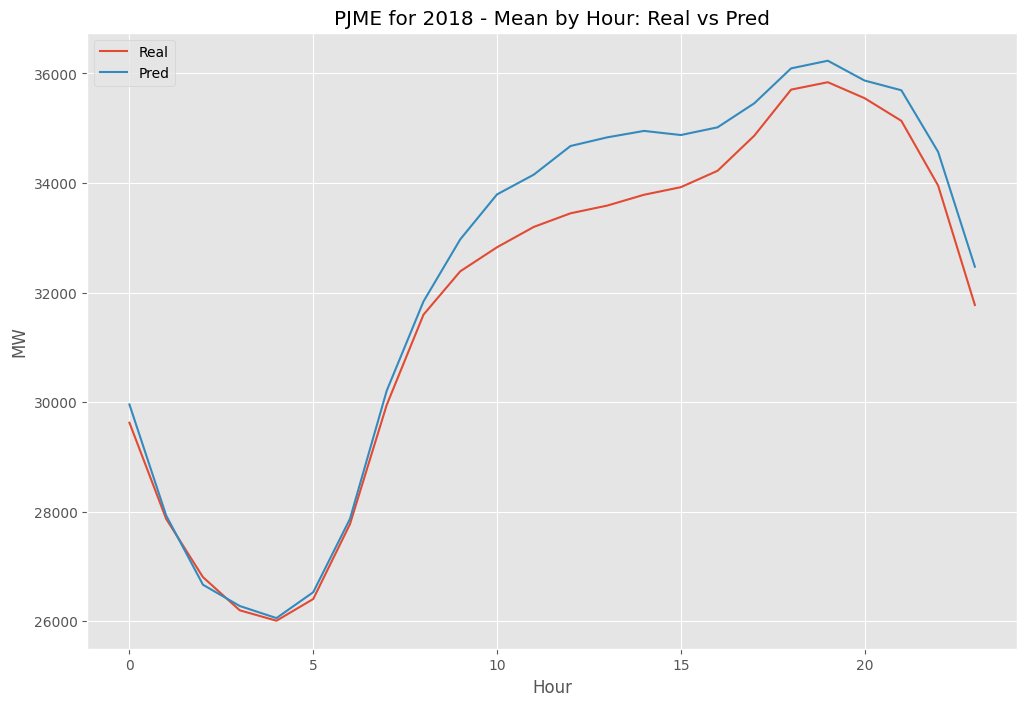

In [43]:
# Create Year and Month features
df_p2_pred_gbHour_meanMW = df_p2_pred[['Hour', 'PJME_MW', 'PJME_MW_Pred']].groupby(['Hour'])[['PJME_MW', 'PJME_MW_Pred']].mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_p2_pred_gbHour_meanMW.reset_index(), x='Hour', y='PJME_MW', label='Real')
sns.lineplot(data=df_p2_pred_gbHour_meanMW.reset_index(), x='Hour', y='PJME_MW_Pred', label='Pred')

plt.title('PJME for 2018 - Mean by Hour: Real vs Pred')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

### Conclusions for Problem 2

We may conclude that the **introduction of time series features**, mainly lags, helped us to improve the performance of the model.

We had to pay attention to the Forecast Origin to understand which data was available for the prediction, so I used values from the **previous years**, taking advantage of the seasonality features of this data.

# Conclusions

We made an exploratory analysis (EDA) to understand the effects of datetime and time series features to the PJME Power Consumption.

The Time Series Features analysis enabled us to analyse the **Stationarity** and **Seasonality** of the series, which helped me undertand which features would have been good for the prediction.

In the Problem 1, since the data was stationary with **strong seasonality patterns**, even only with datetime features, the model performed fairly well to predict the data for 2018.

With the introduction of **time series features** in the Problem 2, the model performance increased, which shows the importance of analysing trends, cycles and partial autocorrelation of the series. 😀